### Homework for the Module 4 of the ML Bootcamp
#### Evaluation Metrics for Classification

For reference of Commands of this course: 
   https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/04-evaluation/notebook.ipynb

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

__Dataset__

In [4]:
file = 'course_lead_scoring.csv'
if os.path.exists(file):
    pass
else:
    data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
    !wget $data -O course_lead_scoring.csv 

--2025-10-22 20:08:30--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.07s   

2025-10-22 20:08:31 (1.10 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



__Data preparation__ 
- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0
- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

In [5]:
df = pd.read_csv('course_lead_scoring.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [7]:
df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(0.0)

In [8]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

numerical_columns.remove('converted')

__Question 1: ROC AUC feature importance__ 

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that
<!-- -->
If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable has the highest AUC?

In [12]:
for numerical in numerical_columns:
    score = roc_auc_score(y_train,df_train[numerical])
    if score<0.5:
        #df_train[numerical]=-df_train[numerical]
        score = roc_auc_score(y_train,(-df_train[numerical]))
    print('AUC Score = %f for %s' % (score, numerical))

AUC Score = 0.763568 for number_of_courses_viewed
AUC Score = 0.551958 for annual_income
AUC Score = 0.738270 for interaction_count
AUC Score = 0.614499 for lead_score


__Question 2: Training the model__ \
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters: \
`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)` \
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [13]:
def train(df, y, C=1.0):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)

    return dv, model

In [14]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [15]:
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)
    
auc = roc_auc_score(y_val, y_pred)
round(auc,3)

0.817

__Question 3: Precision and Recall__ \
Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them 

At which threshold precision and recall curves intersect?

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0,1,101) #thresholds from 0 to 1 with step 0.01

scores = []

for t in thresholds:
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))


columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
    
   # p = tp/(tp+fp)
   # r = tp/(tp+fn)

df_scores['prec'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['rec'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores

,thresholds,tp,fp,fn,tn,prec,rec
0,0.00,171,122,0,0,0.583618,1.000000
1,0.01,171,122,0,0,0.583618,1.000000
2,0.02,171,122,0,0,0.583618,1.000000
3,0.03,171,122,0,0,0.583618,1.000000
4,0.04,171,122,0,0,0.583618,1.000000
...,...,...,...,...,...,...,...
96,0.96,3,0,168,122,1.000000,0.017544
97,0.97,1,0,170,122,1.000000,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000


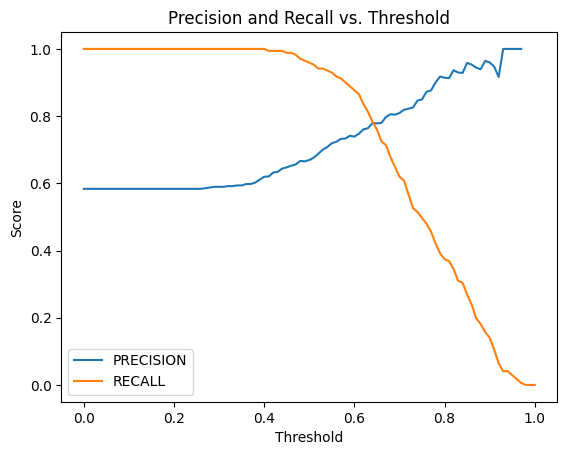

In [17]:
plt.plot(df_scores.thresholds, df_scores['prec'], label='PRECISION')
plt.plot(df_scores.thresholds, df_scores['rec'], label='RECALL')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()

__Question 4: F1 score__ \
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both \
This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 \
At which threshold F1 is maximal?

In [35]:
df_scores['F1'] = 2 * ((df_scores.prec*df_scores.rec)/(df_scores.prec+df_scores.rec))

In [36]:
max_f1_index = df_scores['F1'].argmax()  # Get the index of the maximum F1 score
threshold_best_f1 = thresholds[max_f1_index]  # Access thresholds using the integer index
print("Max threshold F1:", threshold_best_f1, "| F1:", df_scores['F1'].max())

Max threshold F1: 0.5700000000000001 | F1: 0.8124999999999999


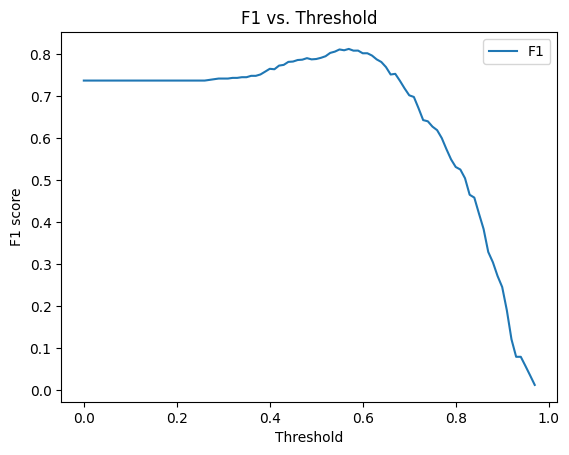

In [37]:
plt.plot(df_scores.thresholds, df_scores['F1'], label='F1')
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 vs. Threshold')
plt.legend()

__Question 5: 5-Fold CV__ \
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds: \
`KFold(n_splits=5, shuffle=True, random_state=1)`
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [38]:
n_splits = 5

scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


__Question 6: Hyperparameter Tuning__ \
Now let's use 5-Fold cross-validation to find the best parameter `C`
- Iterate over the following `C` values: `[0.000001, 0.001, 1]`
- Initialize `KFold` with the same parameters as previously
- Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score? \
If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [39]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s   %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06   0.560 +- 0.024
C=0.001   0.867 +- 0.029
C=1   0.822 +- 0.036
